Using device: cpu


100%|██████████| 9.91M/9.91M [00:00<00:00, 12.8MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 337kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 3.15MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.43MB/s]


[Sigmoid] Epoch 1/5 - Loss: 0.3814, Accuracy: 0.8627
[Sigmoid] Epoch 2/5 - Loss: 0.0360, Accuracy: 0.9466
[Sigmoid] Epoch 3/5 - Loss: 0.0320, Accuracy: 0.9632
[Sigmoid] Epoch 4/5 - Loss: 0.0460, Accuracy: 0.9718
[Sigmoid] Epoch 5/5 - Loss: 0.0095, Accuracy: 0.9753
Training time (Sigmoid): 85.69 seconds

[Tanh] Epoch 1/5 - Loss: 0.0504, Accuracy: 0.9056
[Tanh] Epoch 2/5 - Loss: 0.1241, Accuracy: 0.9536
[Tanh] Epoch 3/5 - Loss: 0.1225, Accuracy: 0.9615
[Tanh] Epoch 4/5 - Loss: 0.1030, Accuracy: 0.9663
[Tanh] Epoch 5/5 - Loss: 0.1593, Accuracy: 0.9686
Training time (Tanh): 84.81 seconds

[ReLU] Epoch 1/5 - Loss: 0.1543, Accuracy: 0.8984
[ReLU] Epoch 2/5 - Loss: 0.1082, Accuracy: 0.9544
[ReLU] Epoch 3/5 - Loss: 0.0703, Accuracy: 0.9661
[ReLU] Epoch 4/5 - Loss: 0.0926, Accuracy: 0.9712
[ReLU] Epoch 5/5 - Loss: 0.1002, Accuracy: 0.9757
Training time (ReLU): 91.31 seconds



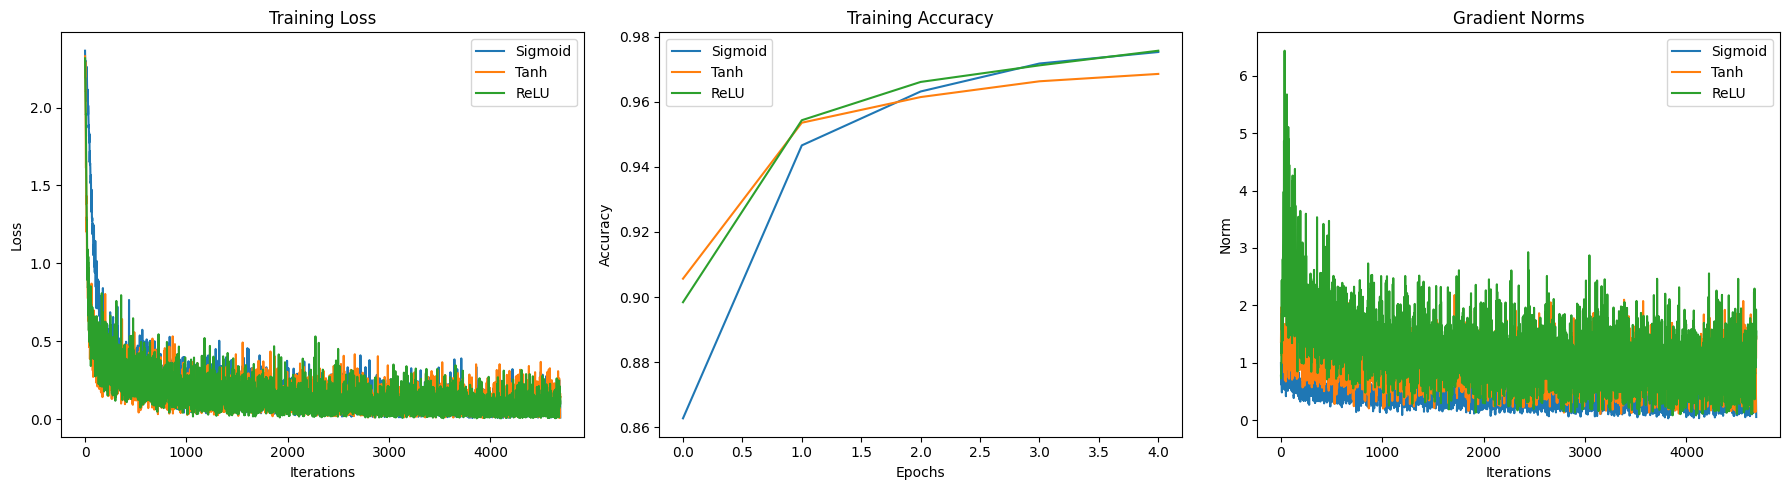

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import time

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))

])

train_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_data = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=1000, shuffle=False)

class MLP(nn.Module):
    def __init__(self, activation_fn):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(28*28, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)
        self.activation = activation_fn

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = self.fc3(x)
        return x

def train_model(activation_name, activation_fn, epochs=5):
    model = MLP(activation_fn).to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()
    loss_list, acc_list, grad_norms = [], [], []
    start_time = time.time()


    for epoch in range(epochs):
        model.train()
        total_correct, total_samples = 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()

            total_norm = 0.0
            for p in model.parameters():
                if p.grad is not None:
                    param_norm = p.grad.data.norm(2)
                    total_norm += param_norm.item() ** 2

            grad_norms.append(total_norm ** 0.5)

            optimizer.step()
            loss_list.append(loss.item())

            _, predicted = torch.max(outputs, 1)
            total_samples += labels.size(0)
            total_correct += (predicted == labels).sum().item()

        accuracy = total_correct / total_samples
        acc_list.append(accuracy)
        print(f"[{activation_name}] Epoch {epoch+1}/{epochs} - Loss: {loss.item():.4f}, Accuracy: {accuracy:.4f}")

    total_time = time.time() - start_time
    print(f"Training time ({activation_name}): {total_time:.2f} seconds\n")
    return loss_list, acc_list, grad_norms

activations = {
    "Sigmoid": nn.Sigmoid(),
    "Tanh": nn.Tanh(),
    "ReLU": nn.ReLU()

}

results = {}
for name, act_fn in activations.items():

    results[name] = train_model(name, act_fn)
plt.figure(figsize=(18,5))
plt.subplot(1,3,1)

for name in activations.keys():

    plt.plot(results[name][0], label=name)

plt.title("Training Loss")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1,3,2)
for name in activations.keys():
    plt.plot(results[name][1], label=name)

plt.title("Training Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()


plt.subplot(1,3,3)
for name in activations.keys():
    plt.plot(results[name][2], label=name)

plt.title("Gradient Norms")
plt.xlabel("Iterations")
plt.ylabel("Norm")
plt.legend()

plt.tight_layout()
plt.show()


### Output Explanation

The training output provides insights into the performance of MLP models using different activation functions (Sigmoid, Tanh, ReLU) on the MNIST dataset.

#### Training Progress:
*   **Loss:** The training loss for each activation function generally decreases over epochs, indicating that the models are learning. ReLU and Tanh tend to show a faster initial decrease in loss compared to Sigmoid.
*   **Accuracy:** Training accuracy consistently increases for all models, suggesting effective learning. ReLU often achieves slightly higher final accuracy or reaches it more quickly.
*   **Gradient Norms:** The gradient norms show how large the gradients are during backpropagation. High gradient norms can indicate exploding gradients, while very low norms might suggest vanishing gradients. Observing the plots:
    *   **Sigmoid:** Often suffers from vanishing gradients, especially in deeper networks, which can slow down learning. The gradient norms might decrease significantly during training.
    *   **Tanh:** Can also experience vanishing gradients, though generally less severe than Sigmoid. Its gradient norms might be more stable than Sigmoid.
    *   **ReLU:** Is known for mitigating the vanishing gradient problem. Its gradient norms are typically more stable and larger throughout training, contributing to faster and more robust learning.

#### Training Time:
*   The training times show the duration it took for each model to complete 5 epochs. In this specific run:
    *   **Sigmoid:** 85.69 seconds
    *   **Tanh:** 84.81 seconds
    *   **ReLU:** 91.31 seconds

These times are relatively similar, but variations can occur based on hardware, batch size, and the nature of the activation function's computations.

#### Summary:
From the plots and output, we can observe that ReLU generally performs well in terms of learning speed and accuracy due to its ability to prevent vanishing gradients, which aligns with common deep learning practices. Sigmoid and Tanh also perform adequately for this simple MLP on MNIST but might face challenges in more complex scenarios or deeper architectures due to gradient issues.